# Machine Learning Project - Cross Domain Plant Species Identitication

# Approach 3

**Triplet Margin Loss using a DINOv2 Feature Extractor**.

The objective is to reduce the domain gap between:
- Herbarium specimens
- Field photographs

Instead of training a classifier directly, this approach uses metric learning to
reshape the embedding space so that:
- Images of the same species from different domains are closer together
- Images of different species are pushed apart

The model is evaluated using multiple classifiers (Prototype, KNN, SVM) and
performance is reported separately for:
- Paired species
- Unpaired species
- Overall dataset

This allows us to measure whether the approach effectively improves cross-domain
recognition and whether it helps with data imbalance.

In [1]:
#connecting to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Import Libraries

In [2]:
# This cell imports all required libraries.
# It includes:
# - PyTorch for model training
# - torchvision for image preprocessing
# - sklearn for evaluation and classification
# - numpy for numerical operations
# - matplotlib for visualisation
#
# The device (CPU / GPU) is also detected here.

import os
import random
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from numpy.linalg import norm
from sklearn.metrics import top_k_accuracy_score
import torch.nn.functional as F

print('PyTorch version:', torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

PyTorch version: 2.9.0+cu126
Using device: cuda


## 2. Data Loading and Exploration
## 2.1 Setting Data Paths

In [3]:
BASE_DIR = "/content/drive/MyDrive/AML_project_herbarium_dataset"
LIST_DIR = f"{BASE_DIR}/list"
train_txt = f"{LIST_DIR}/train.txt"
test_txt = f"{LIST_DIR}/test.txt"
groundtruth_txt = f"{LIST_DIR}/groundtruth.txt"
BEST_MODEL_PATH = os.path.join(BASE_DIR, 'best_model.pth')

print("Paths:")
print("BASE_DIR:", BASE_DIR)
print("LIST_DIR:", LIST_DIR)
print("TRAIN TXT:", train_txt)
print('TEST TXT:', test_txt)
print('GROUND TRUTH TXT:', groundtruth_txt)
print('Best model path:', BEST_MODEL_PATH)


Paths:
BASE_DIR: /content/drive/MyDrive/AML_project_herbarium_dataset
LIST_DIR: /content/drive/MyDrive/AML_project_herbarium_dataset/list
TRAIN TXT: /content/drive/MyDrive/AML_project_herbarium_dataset/list/train.txt
TEST TXT: /content/drive/MyDrive/AML_project_herbarium_dataset/list/test.txt
GROUND TRUTH TXT: /content/drive/MyDrive/AML_project_herbarium_dataset/list/groundtruth.txt
Best model path: /content/drive/MyDrive/AML_project_herbarium_dataset/best_model.pth


### 2.2 Load Training Data (Paths + Labels + Domain)

In [4]:
# Load training data with domain information
img_paths = []
labels = []
domains = []

with open(train_txt, "r") as f:
    for line in f.readlines():
        rel_path, label = line.strip().split()
        full_path = os.path.join(BASE_DIR, rel_path)

        # Determine domain from path
        domain = 'herbarium' if 'herbarium' in rel_path else 'photo'

        img_paths.append(full_path)
        labels.append(int(label))
        domains.append(domain)

print(f"Total training images: {len(img_paths)}")
print(f"Unique species classes: {len(set(labels))}")
print(f"Herbarium images: {domains.count('herbarium')}")
print(f"Photo images: {domains.count('photo')}")

Total training images: 4744
Unique species classes: 100
Herbarium images: 3700
Photo images: 1044


### 2.3 Load Pairing info

In [5]:
# Load class pairing information
with open(os.path.join(LIST_DIR, "class_with_pairs.txt"), "r") as f:
    classes_with_pairs = set(int(line.strip()) for line in f)

with open(os.path.join(LIST_DIR, "class_without_pairs.txt"), "r") as f:
    classes_without_pairs = set(int(line.strip()) for line in f)

print(f"Classes with herbarium-photo pairs: {len(classes_with_pairs)}")
print(f"Classes without pairs (herbarium only): {len(classes_without_pairs)}")

Classes with herbarium-photo pairs: 60
Classes without pairs (herbarium only): 40


### 2.4 Validating Paths(Removing missing files)

In [6]:
# Validate Path
missing = [p for p in img_paths if not os.path.exists(p)]
valid_img_paths = [p for p in img_paths if os.path.exists(p)]
valid_labels   = [labels[i] for i, p in enumerate(img_paths) if os.path.exists(p)]
valid_domains = [domains[i] for i, p in enumerate(img_paths) if os.path.exists(p)]

print(f"Missing: {len(missing)}")
if missing:
    print("Example missing:", missing[:5])
print(f"Valid: {len(valid_img_paths)}")

# Update to use only valid data
img_paths = valid_img_paths
labels = valid_labels
domains = valid_domains

labels = np.array(labels)
domains = np.array(domains)


Missing: 0
Valid: 4744


### 2.4 Defining prepocessing

In [7]:
# Define Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

print("Image transform pipeline ready")


Image transform pipeline ready


### 2.5 Visualize random images from the loaded dataset

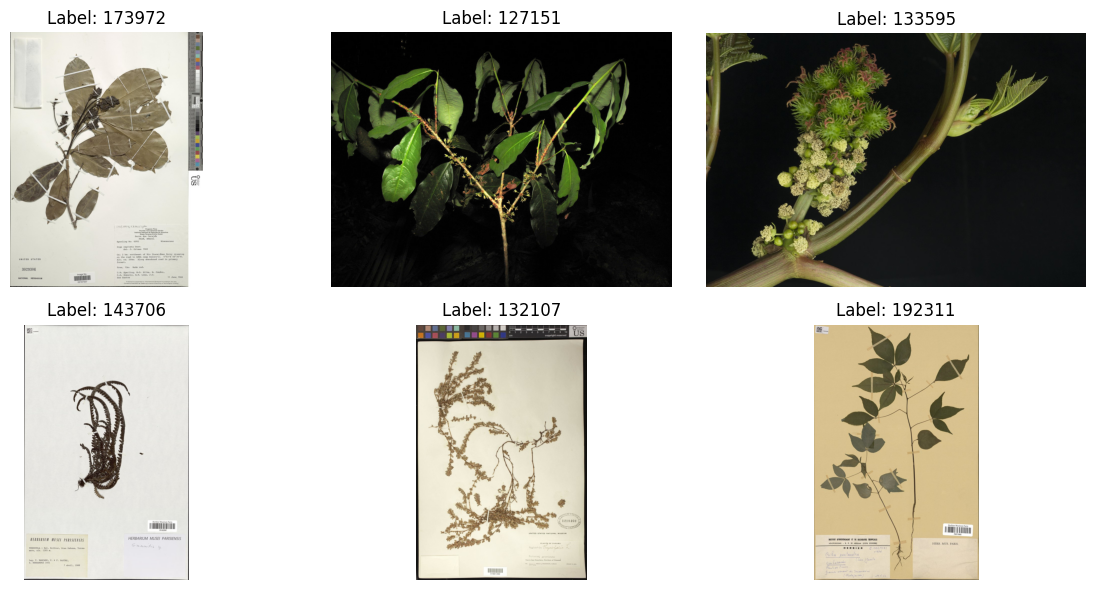

In [8]:
# Visualize a Few Images

sample_indices = random.sample(range(len(img_paths)), 6)
plt.figure(figsize=(12, 6))

for i, idx in enumerate(sample_indices):
    img = Image.open(img_paths[idx]).convert("RGB")
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(f"Label: {labels[idx]}")
    plt.axis("off")

plt.tight_layout()
plt.show()


## 3. DinoV2 Feature Extractor (Using BEST MODEL from Approach 2)

In [9]:
# Inspect best_model.pth  (Approach 2 Best Model)
state_dict = torch.load(BEST_MODEL_PATH, map_location="cpu")

print("Keys inside best_model.pth:")
for k in state_dict.keys():
    print(" -", k)

print("\nTensor shapes:")
for k, v in state_dict.items():
    print(f"{k}: {v.shape}")

print("\nDetailed parameter inspection:")
for k, v in state_dict.items():
    print(f"{k} → min: {v.min():.4f}, max: {v.max():.4f}, mean: {v.mean():.4f}")

print("\nTotal parameters stored:", sum(p.numel() for p in state_dict.values()))

Keys inside best_model.pth:
 - fc.weight
 - fc.bias

Tensor shapes:
fc.weight: torch.Size([100, 768])
fc.bias: torch.Size([100])

Detailed parameter inspection:
fc.weight → min: -0.5733, max: 0.5731, mean: 0.0002
fc.bias → min: -0.1044, max: 0.0818, mean: 0.0000

Total parameters stored: 76900


### 3.1 Load DINO backbone (same one used in Approach 2)

In [10]:
backbone = torch.hub.load("facebookresearch/dinov2", "dinov2_vitb14")
backbone.to(device)
backbone.eval()

# Rebuild the classifier head EXACTLY as used in Approach 2
num_classes = len(set(labels))     # should be 100
classifier_head = nn.Linear(768, num_classes)

# # Fix key names: fc.weight → weight
raw_state = torch.load(BEST_MODEL_PATH, map_location="cpu")
fixed_state = {}
fixed_state["weight"] = raw_state["fc.weight"]
fixed_state["bias"]   = raw_state["fc.bias"]

# load into Linear layer
classifier_head.load_state_dict(fixed_state)
classifier_head.eval()

print("Loaded classifier head from BEST MODEL successfully.")

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Loaded classifier head from BEST MODEL successfully.


### 3.2 REMOVE classifier head → ONLY USE BACKBONE FOR FEATURES

In [11]:
for param in backbone.parameters():
    param.requires_grad = False

#   Feature Extraction Function
@torch.no_grad()
def get_finetuned_embedding(image_path):
    img = Image.open(image_path).convert("RGB")
    x = transform(img).unsqueeze(0).to(device)

    feat = backbone(x)          # [1, 768]
    if isinstance(feat, dict):  # if DINO returns dict
        feat = feat["x_norm"]

    return feat.squeeze(0).cpu()   # [768]

### 3.3 Extract FEATURES from Approach 2's  Best Model

In [12]:
# Extract FEATURES from *Approach 2 Best Model*
train_features = []
train_labels_list = []
train_domains_list = []

for p, lbl, dom in tqdm(zip(img_paths, labels, domains), total=len(img_paths)):
    emb = get_finetuned_embedding(p)
    train_features.append(emb.numpy())
    train_labels_list.append(lbl)
    train_domains_list.append(dom)

train_features = np.array(train_features)
train_labels = np.array(train_labels_list)
train_domains = np.array(train_domains_list)

np.save("ft_features.npy", train_features)
np.save("ft_labels.npy", train_labels)
np.save("ft_domains.npy", train_domains)

print("Saved finetuned features: ft_features.npy")
print("Train feature shape:", train_features.shape)

100%|██████████| 4744/4744 [13:10<00:00,  6.00it/s]

Saved finetuned features: ft_features.npy
Train feature shape: (4744, 768)


### 3.4 Extract Baseline DINO Features (Test)

In [13]:
test_paths = []
test_labels = []

with open(test_txt, "r") as f1, open(groundtruth_txt, "r") as f2:
    for p, l in zip(f1.readlines(), f2.readlines()):
        rel_path = p.strip()
        full_path = os.path.join(BASE_DIR, rel_path)
        test_paths.append(full_path)

        # groundtruth.txt: "test/xxxx.jpg label"
        _, label_str = l.strip().split()
        test_labels.append(int(label_str))

test_paths  = np.array(test_paths)
test_labels = np.array(test_labels)

print("Total test images:", len(test_paths))
print("Total groundtruth labels:", len(test_labels))

Total test images: 207
Total groundtruth labels: 207


### 3.5 Test Feature Extraction

In [14]:
test_features = []
print("Extracting TEST embeddings from BEST MODEL backbone...")

for path in tqdm(test_paths):
    emb = get_finetuned_embedding(path)
    test_features.append(emb.numpy())

test_features = np.array(test_features)

np.save("ft_test_features.npy", test_features)
np.save("ft_test_labels.npy", test_labels)

print("Saved finetuned TEST features → ft_test_features.npy")
print("Test feature shape:", test_features.shape)


Extracting TEST embeddings from BEST MODEL backbone...


100%|██████████| 207/207 [01:03<00:00,  3.28it/s]

Saved finetuned TEST features → ft_test_features.npy
Test feature shape: (207, 768)


## 4. Triplet Loss Training

In [45]:
# Cross-Domain Triplet Dataset
class ImageTripletDataset(Dataset):
    """
    Triplet dataset that enforces cross-domain positive pairs
    - Anchor: herbarium image (paired class)
    - Positive: photo image of SAME species (cross-domain)
    - Negative: herbarium/photo of DIFFERENT species
    """
    def __init__(self, img_paths, labels, domains, classes_with_pairs, transform):
        self.img_paths = img_paths
        self.labels = np.array(labels)
        self.domains = np.array(domains)
        self.transform = transform
        self.classes_with_pairs = classes_with_pairs

        # build indexes per class per domain
        self.class_domain_indices = {}
        for i, (c, d) in enumerate(zip(self.labels, self.domains)):
            if c not in self.class_domain_indices:
                self.class_domain_indices[c] = {"herbarium": [], "photo": []}
            self.class_domain_indices[c][d].append(i)

        # valid anchors: herbarium images with photo pairs
        self.valid_anchors = [
            i for i, (c, d) in enumerate(zip(self.labels, self.domains))
            if d == "herbarium"
            and c in self.classes_with_pairs
            and len(self.class_domain_indices[c]["photo"]) > 0
        ]

        self.all_classes = list(self.class_domain_indices.keys())
        print(f"[Triplet] Valid anchors: {len(self.valid_anchors)}")

    def __len__(self):
        return len(self.valid_anchors)

    def __getitem__(self, idx):
        a_idx = self.valid_anchors[idx]
        a_lbl = self.labels[a_idx]

        # positive
        p_idx = np.random.choice(self.class_domain_indices[a_lbl]["photo"])
        # negative
        neg_lbl = a_lbl
        while neg_lbl == a_lbl:
            neg_lbl = np.random.choice(self.all_classes)

        neg_domain = np.random.choice(["herbarium", "photo"])
        neg_candidates = self.class_domain_indices[neg_lbl][neg_domain]
        if len(neg_candidates) == 0:
            neg_domain = "photo" if neg_domain == "herbarium" else "herbarium"
            neg_candidates = self.class_domain_indices[neg_lbl][neg_domain]

        n_idx = np.random.choice(neg_candidates)

        anc = self.transform(Image.open(self.img_paths[a_idx]).convert("RGB"))
        pos = self.transform(Image.open(self.img_paths[p_idx]).convert("RGB"))
        neg = self.transform(Image.open(self.img_paths[n_idx]).convert("RGB"))

        return anc, pos, neg

### 4.2  Projection Head (Trainable Layer)

In [46]:
class ProjectionHead(nn.Module):
    def __init__(self, in_dim=768, out_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, out_dim)
        )

    def forward(self, x):
        return self.net(x)

### 4.3 Wrap DINO backbone + projection head (Triplet embedding model)

In [47]:
class DinoTripletModel(nn.Module):
    def __init__(self, backbone, proj_dim=256):
        super().__init__()
        self.backbone = backbone
        self.proj_head = ProjectionHead(768, proj_dim)

    def forward(self, x):
        feats = self.backbone(x)
        if isinstance(feats, dict):
            feats = feats["x_norm"]
        return self.proj_head(feats)

### 4.4 Partial Fine-Tuning Setup

In [48]:
triplet_dataset = ImageTripletDataset(
    img_paths=img_paths,
    labels=labels,
    domains=domains,
    classes_with_pairs=classes_with_pairs,
    transform=transform,
)

triplet_loader = DataLoader(
    triplet_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

print("Triplet image dataset ready. Total anchors:", len(triplet_dataset))

[Triplet] Valid anchors: 1956
Triplet image dataset ready. Total anchors: 1956


In [49]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Triplet training on: {device}")

# use SAME backbone from Approach 2
triplet_backbone = backbone
triplet_backbone = triplet_backbone.to(device)
triplet_backbone.train()

## Freeze all parameters first
for p in triplet_backbone.parameters():
    p.requires_grad = False

# Unfreeze only last 2 transformer blocks + final norm
for name, p in triplet_backbone.named_parameters():
    if "blocks.10" in name or "blocks.11" in name or "norm" in name:
        p.requires_grad = True

triplet_model = DinoTripletModel(triplet_backbone, proj_dim=256).to(device)

# Ensure projection head is trainable
for p in triplet_model.proj_head.parameters():
    p.requires_grad = True

# Optimizer: only trainable params
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, triplet_model.parameters()),
    lr=1e-5
)

criterion = nn.TripletMarginLoss(margin=0.5)

# Training loop
num_epochs = 30
epoch_losses = []

print("\nStarting Triplet Fine-Tuning (partial DINO backbone)...")

for epoch in range(num_epochs):
    triplet_model.train()
    total_loss = 0

    for anc, pos, neg in triplet_loader:
        anc, pos, neg = anc.to(device), pos.to(device), neg.to(device)

        a = triplet_model(anc)
        p = triplet_model(pos)
        n = triplet_model(neg)

        loss = criterion(a, p, n)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg = total_loss / len(triplet_loader)
    epoch_losses.append(avg)
    print(f"Epoch {epoch+1}/{num_epochs} | Loss = {avg:.4f}")

Triplet training on: cuda

Starting Triplet Fine-Tuning (partial DINO backbone)...
Epoch 1/30 | Loss = 0.0482
Epoch 2/30 | Loss = 0.0361
Epoch 3/30 | Loss = 0.0335
Epoch 4/30 | Loss = 0.0307
Epoch 5/30 | Loss = 0.0227
Epoch 6/30 | Loss = 0.0229
Epoch 7/30 | Loss = 0.0217
Epoch 8/30 | Loss = 0.0297
Epoch 9/30 | Loss = 0.0217
Epoch 10/30 | Loss = 0.0203
Epoch 11/30 | Loss = 0.0197
Epoch 12/30 | Loss = 0.0152
Epoch 13/30 | Loss = 0.0236
Epoch 14/30 | Loss = 0.0303
Epoch 15/30 | Loss = 0.0246
Epoch 16/30 | Loss = 0.0195
Epoch 17/30 | Loss = 0.0198
Epoch 18/30 | Loss = 0.0204
Epoch 19/30 | Loss = 0.0224
Epoch 20/30 | Loss = 0.0156
Epoch 21/30 | Loss = 0.0165
Epoch 22/30 | Loss = 0.0152
Epoch 23/30 | Loss = 0.0161
Epoch 24/30 | Loss = 0.0187
Epoch 25/30 | Loss = 0.0162
Epoch 26/30 | Loss = 0.0157
Epoch 27/30 | Loss = 0.0094
Epoch 28/30 | Loss = 0.0134
Epoch 29/30 | Loss = 0.0157
Epoch 30/30 | Loss = 0.0130


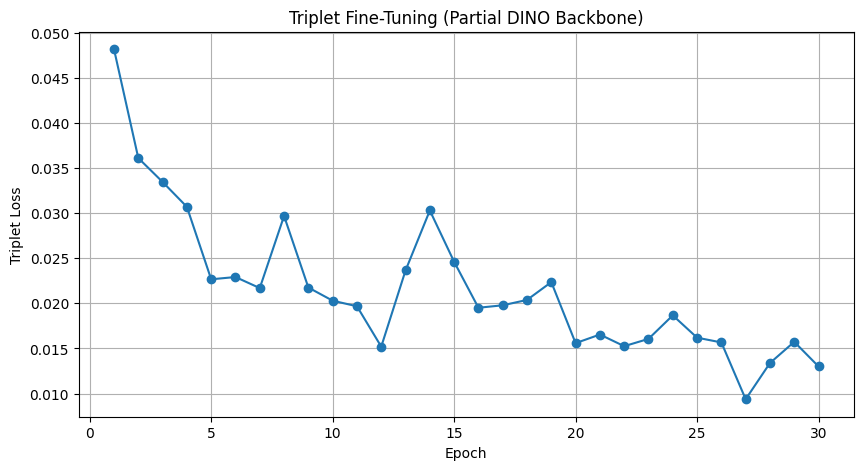


Saved triplet fine-tuned model → triplet_dino_model.pth


In [50]:
plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), epoch_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Triplet Loss')
plt.title('Triplet Fine-Tuning (Partial DINO Backbone)')
plt.grid(True)
plt.show()

# Save fine-tuned triplet model
torch.save(triplet_model.state_dict(), "triplet_dino_model.pth")
print("\nSaved triplet fine-tuned model → triplet_dino_model.pth")

In [51]:
# TRAIN embeddings
triplet_model.eval()
proj_train = []

with torch.no_grad():
    for path in tqdm(img_paths, desc="Triplet embeddings (train)"):
        img = Image.open(path).convert("RGB")
        x = transform(img).unsqueeze(0).to(device)
        emb = triplet_model(x)
        proj_train.append(emb.cpu().squeeze(0).numpy())

proj_train = np.array(proj_train)
np.save("projected_features.npy", proj_train)
print("Saved triplet train embeddings → projected_features.npy")

Triplet embeddings (train): 100%|██████████| 4744/4744 [02:21<00:00, 33.47it/s]

Saved triplet train embeddings → projected_features.npy


In [52]:
# TEST embeddings
proj_test = []

with torch.no_grad():
    for path in tqdm(test_paths, desc="Triplet embeddings (test)"):
        img = Image.open(path).convert("RGB")
        x = transform(img).unsqueeze(0).to(device)
        emb = triplet_model(x)
        proj_test.append(emb.cpu().squeeze(0).numpy())

proj_test = np.array(proj_test)
np.save("test_projected_features.npy", proj_test)
print("Saved triplet test embeddings → test_projected_features.npy")

Triplet embeddings (test): 100%|██████████| 207/207 [00:06<00:00, 30.82it/s]

Saved triplet test embeddings → test_projected_features.npy


## 5. Evaluation

### Evaluation: KNN / SVM / Prototype / t-SNE

This section evaluates both the baseline DINO embeddings and the triplet-trained embeddings
using multiple classification and visualization techniques.

##### Uses:
- train_features, test_features   → Baseline DINO embeddings  
- proj_train, proj_test           → Triplet-trained embeddings  

#### Classifiers:
- K-Nearest Neighbours (KNN)
- Support Vector Machine (SVM)
- Prototype Classifier (Cosine Similarity)
- Weighted Prototype Classifier
- Ensemble Classifier (Prototype + SVM)

#### Evaluation Metrics:
- Overall accuracy
- Paired species accuracy
- Unpaired species accuracy
- Top-1 accuracy
- Top-5 accuracy

#### Additional Evaluation:
- Retrieval accuracy (Top-K search)
- Confusion matrix analysis

#### Visualization:
- t-SNE / PCA embedding projection
- Loss curve visualisation

This evaluation allows us to analyze classification performance, embedding quality,
and robustness under class imbalance and domain shift.


### 5.1 KNN Classifier

In [53]:
# Reload from disk to be safe
train_features = np.load("ft_features.npy")
train_labels   = np.load("ft_labels.npy")
train_domains  = np.load("ft_domains.npy")

test_features = np.load("ft_test_features.npy")
test_labels   = np.load("ft_test_labels.npy")

proj_train = np.load("projected_features.npy")
proj_test  = np.load("test_projected_features.npy")

In [54]:
# Masks for paired/unpaired
paired_mask   = np.isin(test_labels, list(classes_with_pairs))
unpaired_mask = np.isin(test_labels, list(classes_without_pairs))
all_classes   = np.unique(train_labels)

In [55]:
# BASELINE DINO + KNN
knn_base = KNeighborsClassifier(n_neighbors=5)
knn_base.fit(train_features, train_labels)

preds_knn_base = knn_base.predict(test_features)
proba_knn_base = knn_base.predict_proba(test_features)

# Overall
knn_base_top1 = (preds_knn_base == test_labels).mean()
knn_base_top5 = top_k_accuracy_score(test_labels, proba_knn_base, k=5, labels=all_classes)

# Paired
knn_base_paired_top1 = (preds_knn_base[paired_mask] == test_labels[paired_mask]).mean()
knn_base_paired_top5 = top_k_accuracy_score(
    test_labels[paired_mask],
    proba_knn_base[paired_mask],
    k=5, labels=all_classes
)

# Unpaired
knn_base_unpaired_top1 = (preds_knn_base[unpaired_mask] == test_labels[unpaired_mask]).mean()
knn_base_unpaired_top5 = top_k_accuracy_score(
    test_labels[unpaired_mask],
    proba_knn_base[unpaired_mask],
    k=5, labels=all_classes
)

print("\nBaseline DINO + KNN ")
print(f"Overall  - Top1: {knn_base_top1:.4f} | Top5: {knn_base_top5:.4f}")
print(f"Paired   - Top1: {knn_base_paired_top1:.4f} | Top5: {knn_base_paired_top5:.4f}")
print(f"Unpaired - Top1: {knn_base_unpaired_top1:.4f} | Top5: {knn_base_unpaired_top5:.4f}")


Baseline DINO + KNN 
Overall  - Top1: 0.7101 | Top5: 0.8068
Paired   - Top1: 0.8693 | Top5: 0.9673
Unpaired - Top1: 0.2593 | Top5: 0.3519


In [56]:
# TRIPLET DINO + KNN
knn_trip = KNeighborsClassifier(n_neighbors=5)
knn_trip.fit(proj_train, train_labels)

preds_knn_trip = knn_trip.predict(proj_test)
proba_knn_trip = knn_trip.predict_proba(proj_test)

# Overall
trip_overall_top1 = (preds_knn_trip == test_labels).mean()
trip_overall_top5 = top_k_accuracy_score(test_labels, proba_knn_trip, k=5, labels=all_classes)

# Paired
trip_paired_top1 = (preds_knn_trip[paired_mask] == test_labels[paired_mask]).mean()
trip_paired_top5 = top_k_accuracy_score(
    test_labels[paired_mask],
    proba_knn_trip[paired_mask],
    k=5, labels=all_classes
)

# Unpaired
trip_unpaired_top1 = (preds_knn_trip[unpaired_mask] == test_labels[unpaired_mask]).mean()
trip_unpaired_top5 = top_k_accuracy_score(
    test_labels[unpaired_mask],
    proba_knn_trip[unpaired_mask],
    k=5, labels=all_classes
)

print("\nTriplet DINO + KNN")
print(f"Overall  - Top1: {trip_overall_top1:.4f} | Top5: {trip_overall_top5:.4f}")
print(f"Paired   - Top1: {trip_paired_top1:.4f} | Top5: {trip_paired_top5:.4f}")
print(f"Unpaired - Top1: {trip_unpaired_top1:.4f} | Top5: {trip_unpaired_top5:.4f}")


Triplet DINO + KNN
Overall  - Top1: 0.6425 | Top5: 0.7150
Paired   - Top1: 0.8693 | Top5: 0.9673
Unpaired - Top1: 0.0000 | Top5: 0.0000


In [57]:
print("\n=== Classification Report: Baseline DINO + KNN ===")
print(classification_report(test_labels, preds_knn_base, zero_division=0))

print("\n=== Classification Report: Triplet Embeddings + KNN ===")
print(classification_report(test_labels, preds_knn_trip, zero_division=0))


=== Classification Report: Baseline DINO + KNN ===
              precision    recall  f1-score   support

       12254       1.00      0.50      0.67         2
       12518       0.75      1.00      0.86         3
       12910       0.50      0.67      0.57         3
       12922       1.00      1.00      1.00         2
       13276       0.00      0.00      0.00         1
       13325       0.00      0.00      0.00         1
       13330       0.67      1.00      0.80         2
       13370       0.60      1.00      0.75         3
       14353       1.00      1.00      1.00         2
       14401       0.00      0.00      0.00         1
       15014       0.00      0.00      0.00         1
       15318       0.67      1.00      0.80         2
       15330       1.00      1.00      1.00         1
       15355       0.67      1.00      0.80         2
       19165       1.00      1.00      1.00         3
       19489       1.00      1.00      1.00         3
       29686       0.75      

### 5.2 Prototype Classifier

In [58]:
# Prototype Classifier (Cosine Similarity)

# Helper: Compute prototypes
def build_prototypes(features, labels):
    """
    Compute the mean embedding (prototype) for each class.
    """
    classes = np.unique(labels)
    protos = []

    for c in classes:
        protos.append(features[labels == c].mean(axis=0))

    protos = np.stack(protos, axis=0)   # shape: [num_classes, embedding_dim]
    return classes, protos

# Cosine similarity function
def cosine_proto_predict(test_feats, classes, protos, topk=5):

    # Normalize for cosine similarity
    proto_norm = protos / norm(protos, axis=1, keepdims=True)
    test_norm  = test_feats / norm(test_feats, axis=1, keepdims=True)

    # Cosine similarity matrix [num_test, num_classes]
    sims = test_norm @ proto_norm.T

    # Top-k class indices (descending sim)
    topk_idx = np.argsort(-sims, axis=1)[:, :topk]

    # Top-1 predictions
    preds_top1 = topk_idx[:, 0]

    return sims, preds_top1, topk_idx


In [59]:
print("Baseline DINO + Prototype Classifier")

# Build prototypes using baseline DINO features
base_classes, base_protos = build_prototypes(train_features, train_labels)

# Predict using cosine similarity
sims_base, base_top1_idx, base_topk_idx = cosine_proto_predict(
    test_features, base_classes, base_protos, topk=5
)

# Convert predicted indices → actual labels
base_preds_top1 = base_classes[base_top1_idx]
base_preds_top5 = base_classes[base_topk_idx]   # shape [N, 5]

# Overall accuracy
base_overall_top1 = (base_preds_top1 == test_labels).mean()
base_overall_top5 = np.mean([
    tl in row for tl, row in zip(test_labels, base_preds_top5)
])

# Paired accuracy
base_paired_top1 = (base_preds_top1[paired_mask] == test_labels[paired_mask]).mean()
base_paired_top5 = np.mean([
    tl in row for tl, row in zip(test_labels[paired_mask], base_preds_top5[paired_mask])
])

# Unpaired accuracy
base_unpaired_top1 = (base_preds_top1[unpaired_mask] == test_labels[unpaired_mask]).mean()
base_unpaired_top5 = np.mean([
    tl in row for tl, row in zip(test_labels[unpaired_mask], base_preds_top5[unpaired_mask])
])

print(f"Overall  - Top1: {base_overall_top1:.4f} | Top5: {base_overall_top5:.4f}")
print(f"Paired   - Top1: {base_paired_top1:.4f} | Top5: {base_paired_top5:.4f}")
print(f"Unpaired - Top1: {base_unpaired_top1:.4f} | Top5: {base_unpaired_top5:.4f}\n")


Baseline DINO + Prototype Classifier
Overall  - Top1: 0.6039 | Top5: 0.7874
Paired   - Top1: 0.7582 | Top5: 0.9150
Unpaired - Top1: 0.1667 | Top5: 0.4259



In [60]:
print("Triplet Embeddings + Prototype Classifier")

# Build prototypes using triplet-projected embeddings
trip_classes, trip_protos = build_prototypes(proj_train, train_labels)

# Predict using cosine similarity
sims_trip, trip_top1_idx, trip_topk_idx = cosine_proto_predict(
    proj_test, trip_classes, trip_protos, topk=5
)

trip_preds_top1 = trip_classes[trip_top1_idx]
trip_preds_top5 = trip_classes[trip_topk_idx]

# Overall accuracy

trip_overall_top1 = (trip_preds_top1 == test_labels).mean()
trip_overall_top5 = np.mean([
    tl in row for tl, row in zip(test_labels, trip_preds_top5)
])

# Paired accuracy
trip_paired_top1 = (trip_preds_top1[paired_mask] == test_labels[paired_mask]).mean()
trip_paired_top5 = np.mean([
    tl in row for tl, row in zip(test_labels[paired_mask], trip_preds_top5[paired_mask])
])

# Unpaired accuracy
trip_unpaired_top1 = (trip_preds_top1[unpaired_mask] == test_labels[unpaired_mask]).mean()
trip_unpaired_top5 = np.mean([
    tl in row for tl, row in zip(test_labels[unpaired_mask], trip_preds_top5[unpaired_mask])
])

print(f"Overall  - Top1: {trip_overall_top1:.4f} | Top5: {trip_overall_top5:.4f}")
print(f"Paired   - Top1: {trip_paired_top1:.4f} | Top5: {trip_paired_top5:.4f}")
print(f"Unpaired - Top1: {trip_unpaired_top1:.4f} | Top5: {trip_unpaired_top5:.4f}")


Triplet Embeddings + Prototype Classifier
Overall  - Top1: 0.6425 | Top5: 0.8213
Paired   - Top1: 0.7974 | Top5: 0.9281
Unpaired - Top1: 0.2037 | Top5: 0.5185


In [61]:
print("\n=== Classification Report: Baseline DINO + Prototype ===")
print(classification_report(test_labels, base_preds_top1, zero_division=0))

print("\n=== Classification Report: Triplet Embeddings + Prototype ===")
print(classification_report(test_labels, trip_preds_top1, zero_division=0))


=== Classification Report: Baseline DINO + Prototype ===
              precision    recall  f1-score   support

       12254       1.00      0.50      0.67         2
       12518       0.67      0.67      0.67         3
       12910       1.00      1.00      1.00         3
       12922       1.00      1.00      1.00         2
       13276       0.00      0.00      0.00         1
       13325       0.00      0.00      0.00         1
       13330       0.50      1.00      0.67         2
       13370       0.43      1.00      0.60         3
       14353       1.00      1.00      1.00         2
       14401       0.00      0.00      0.00         1
       15014       0.00      0.00      0.00         1
       15318       0.33      1.00      0.50         2
       15330       0.00      0.00      0.00         1
       15355       0.00      0.00      0.00         2
       19165       0.75      1.00      0.86         3
       19489       1.00      1.00      1.00         3
       29686       0.67

### 5.3 WEIGHTED PROTOTYPE CLASSIFIER (IMBALANCE FIX)

In [64]:
from numpy.linalg import norm

def build_weighted_prototypes(features, labels):
    counts = Counter(labels)
    classes = np.unique(labels)
    protos = []

    for c in classes:
        cls_feats = features[labels == c]
        weight = 1.0 / counts[c]
        proto = cls_feats.mean(axis=0) * weight
        protos.append(proto)

    return classes, np.array(protos)

def cosine_proto_predict(test_feats, classes, protos):
    proto_norm = protos / norm(protos, axis=1, keepdims=True)
    test_norm = test_feats / norm(test_feats, axis=1, keepdims=True)
    sims = test_norm @ proto_norm.T
    return sims

# build weighted prototypes
w_classes, w_protos = build_weighted_prototypes(proj_train, train_labels)

# cosine similarities
sims_w = cosine_proto_predict(proj_test, w_classes, w_protos)

# predictions
pred_idx = np.argmax(sims_w, axis=1)
pred_labels = w_classes[pred_idx]

# evaluate
res_weighted = evaluate_split(pred_labels, sims_w)

print("\nTriplet + WEIGHTED PROTOTYPE")
for k, v in res_weighted.items():
    print(k, ":", round(v, 4))



Triplet + WEIGHTED PROTOTYPE
overall_top1 : 0.6425
paired_top1 : 0.7974
unpaired_top1 : 0.2037
overall_top5 : 0.8213
paired_top5 : 0.9281
unpaired_top5 : 0.5185


## 5.3 COSINE KNN


In [65]:
knn_cos = KNeighborsClassifier(n_neighbors=5, metric="cosine")
knn_cos.fit(proj_train, train_labels)

pred = knn_cos.predict(proj_test)
proba = knn_cos.predict_proba(proj_test)

res_knn = evaluate_split(pred, proba)

print("\nTriplet + COSINE KNN")
for k, v in res_knn.items():
    print(k, ":", round(v, 4))



Triplet + COSINE KNN
overall_top1 : 0.6763
paired_top1 : 0.8758
unpaired_top1 : 0.1111
overall_top5 : 0.7633
paired_top5 : 0.9673
unpaired_top5 : 0.1852


triplet + KNN coinsine

In [68]:
knn_cos = KNeighborsClassifier(n_neighbors=5, metric="cosine")
knn_cos.fit(proj_train, train_labels)

pred = knn_cos.predict(proj_test)
proba = knn_cos.predict_proba(proj_test)

res_knn = evaluate_split(pred, proba)

print("\nTriplet + COSINE KNN")
for k, v in res_knn.items():
    print(k, ":", round(v, 4))



Triplet + COSINE KNN
overall_top1 : 0.6763
paired_top1 : 0.8758
unpaired_top1 : 0.1111
overall_top5 : 0.7633
paired_top5 : 0.9673
unpaired_top5 : 0.1852


In [69]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=2000)
logreg.fit(proj_train, train_labels)

pred = logreg.predict(proj_test)
proba = logreg.predict_proba(proj_test)

res_logreg = evaluate_split(pred, proba)

print("\nTriplet Embeddings + Logistic Regression")
print(f"Overall  - Top1: {res_logreg['overall_top1']:.4f} | Top5: {res_logreg['overall_top5']:.4f}")
print(f"Paired   - Top1: {res_logreg['paired_top1']:.4f} | Top5: {res_logreg['paired_top5']:.4f}")
print(f"Unpaired - Top1: {res_logreg['unpaired_top1']:.4f} | Top5: {res_logreg['unpaired_top5']:.4f}")



Triplet Embeddings + Logistic Regression
Overall  - Top1: 0.6715 | Top5: 0.8116
Paired   - Top1: 0.8758 | Top5: 0.9608
Unpaired - Top1: 0.0926 | Top5: 0.3889


In [71]:
from numpy.linalg import norm

# build class centroids (mean vectors)
classes = np.unique(train_labels)
centroids = []

for c in classes:
    centroids.append(proj_train[train_labels == c].mean(axis=0))

centroids = np.array(centroids)

# normalize
centroids = centroids / norm(centroids, axis=1, keepdims=True)
test_norm = proj_test / norm(proj_test, axis=1, keepdims=True)

# cosine similarity
sims = test_norm @ centroids.T

# predictions
preds = classes[np.argmax(sims, axis=1)]

res_centroid_cos = evaluate_split(preds, sims)

print("\nTriplet Embeddings + Nearest Centroid (Cosine, Manual)")
print(f"Overall  - Top1: {res_centroid_cos['overall_top1']:.4f} | Top5: {res_centroid_cos['overall_top5']:.4f}")
print(f"Paired   - Top1: {res_centroid_cos['paired_top1']:.4f} | Top5: {res_centroid_cos['paired_top5']:.4f}")
print(f"Unpaired - Top1: {res_centroid_cos['unpaired_top1']:.4f} | Top5: {res_centroid_cos['unpaired_top5']:.4f}")



Triplet Embeddings + Nearest Centroid (Cosine, Manual)
Overall  - Top1: 0.6425 | Top5: 0.8213
Paired   - Top1: 0.7974 | Top5: 0.9281
Unpaired - Top1: 0.2037 | Top5: 0.5185


### 6. Visualization

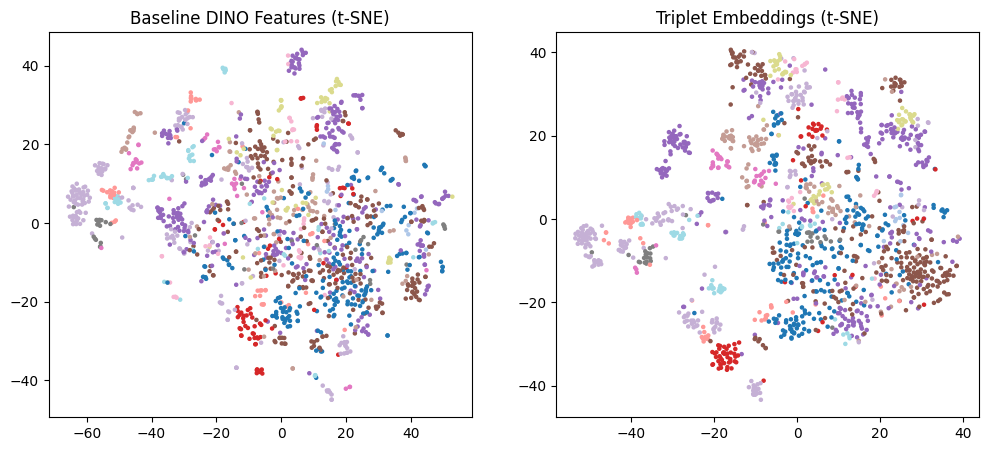

In [72]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# sample for faster visualization
N = min(1500, len(train_labels))
idx = np.random.choice(len(train_labels), N, replace=False)

base_sample = train_features[idx]
trip_sample = proj_train[idx]
label_sample = train_labels[idx]
domain_sample = train_domains[idx]

# TSNE
tsne_base = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(base_sample)
tsne_trip = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(trip_sample)

# Plot
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(tsne_base[:,0], tsne_base[:,1], c=label_sample, s=5, cmap='tab20')
plt.title("Baseline DINO Features (t-SNE)")

plt.subplot(1,2,2)
plt.scatter(tsne_trip[:,0], tsne_trip[:,1], c=label_sample, s=5, cmap='tab20')
plt.title("Triplet Embeddings (t-SNE)")

plt.show()


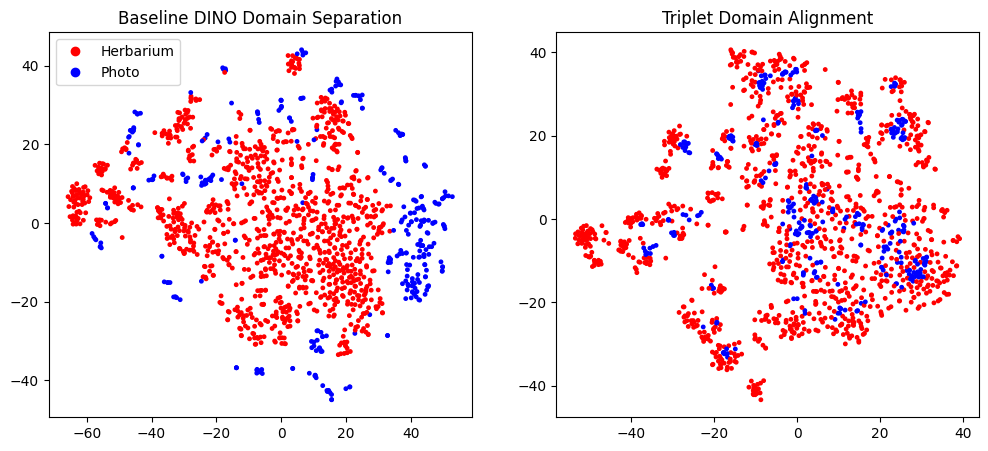

In [73]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
colors = ['red' if d == 'herbarium' else 'blue' for d in domain_sample]
plt.scatter(tsne_base[:,0], tsne_base[:,1], c=colors, s=6)
plt.title("Baseline DINO Domain Separation")
plt.legend(handles=[
    plt.Line2D([0],[0], marker='o', label='Herbarium', color='red', linestyle=''),
    plt.Line2D([0],[0], marker='o', label='Photo', color='blue', linestyle='')
])

plt.subplot(1,2,2)
plt.scatter(tsne_trip[:,0], tsne_trip[:,1], c=colors, s=6)
plt.title("Triplet Domain Alignment")

plt.show()


 5) DISTANCE DISTRIBUTION (Optional but Beautiful)

Shows same-class vs different-class distances.

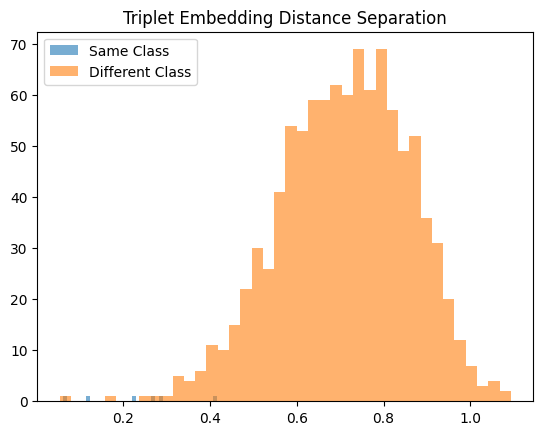

In [76]:
from scipy.spatial.distance import cosine
import random

same, diff = [], []

for _ in range(1000):
    i, j = random.sample(range(len(proj_train)), 2)
    if train_labels[i] == train_labels[j]:
        same.append(cosine(proj_train[i], proj_train[j]))
    else:
        diff.append(cosine(proj_train[i], proj_train[j]))

plt.hist(same, bins=40, alpha=0.6, label='Same Class')
plt.hist(diff, bins=40, alpha=0.6, label='Different Class')
plt.title("Triplet Embedding Distance Separation")
plt.legend()
plt.show()


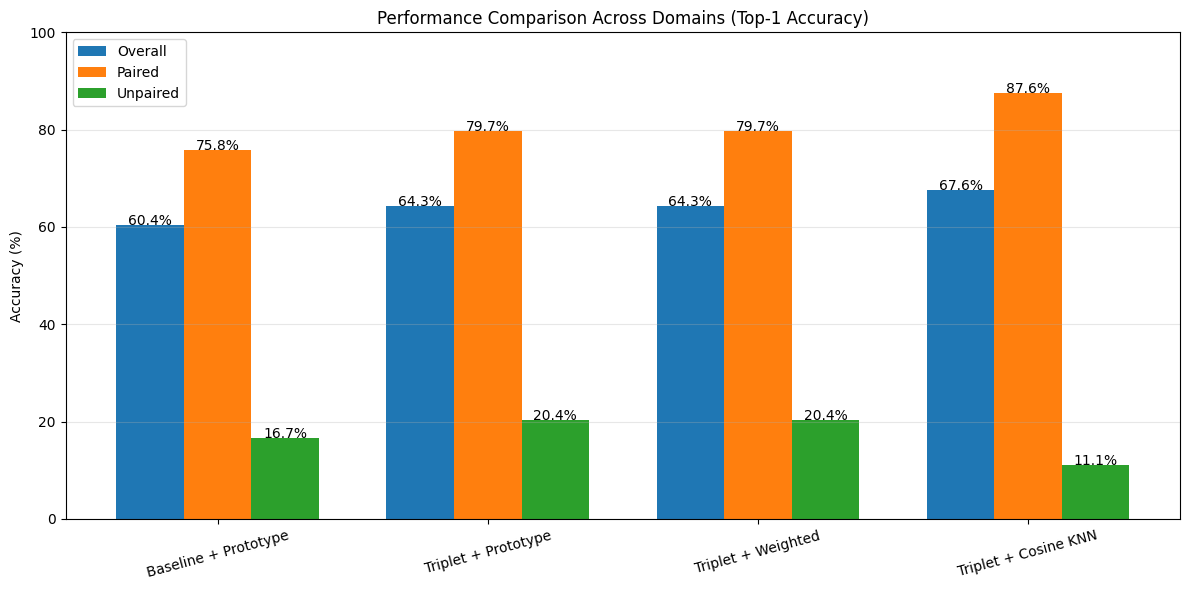

In [78]:
import numpy as np
import matplotlib.pyplot as plt

# MODEL NAMES
models = [
    "Baseline + Prototype",
    "Triplet + Prototype",
    "Triplet + Weighted",
    "Triplet + Cosine KNN"
]

# ACCURACY VALUES (Top-1)
overall = [
    base_overall_top1 * 100,
    trip_overall_top1 * 100,
    res_weighted['overall_top1'] * 100,
    res_knn['overall_top1'] * 100
]

paired = [
    base_paired_top1 * 100,
    trip_paired_top1 * 100,
    res_weighted['paired_top1'] * 100,
    res_knn['paired_top1'] * 100
]

unpaired = [
    base_unpaired_top1 * 100,
    trip_unpaired_top1 * 100,
    res_weighted['unpaired_top1'] * 100,
    res_knn['unpaired_top1'] * 100
]

# BAR POSITIONING
x = np.arange(len(models))
width = 0.25

plt.figure(figsize=(12,6))

plt.bar(x - width, overall, width, label="Overall")
plt.bar(x, paired, width, label="Paired")
plt.bar(x + width, unpaired, width, label="Unpaired")

# LABELS
plt.xticks(x, models, rotation=15)
plt.ylabel("Accuracy (%)")
plt.title("Performance Comparison Across Domains (Top-1 Accuracy)")
plt.legend()
plt.ylim(0,100)
plt.grid(axis='y', alpha=0.3)

# VALUE LABELS
for i in range(len(models)):
    plt.text(x[i]-width, overall[i], f"{overall[i]:.1f}%", ha='center')
    plt.text(x[i], paired[i], f"{paired[i]:.1f}%", ha='center')
    plt.text(x[i]+width, unpaired[i], f"{unpaired[i]:.1f}%", ha='center')

plt.tight_layout()
plt.show()
